# Тестовое задание на вакансию ML/CV Engineer в EVA Lab

## 1. Импорт библиотек и модулей

In [1]:
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
from PIL import Image
import os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import os
from torchvision.ops.boxes import nms
from google.colab.patches import cv2_imshow
from google.colab import drive, files

## 2. Работа с датафреймами

Ссылка на сайт, предоставляющий для загрузки архив с набором данных для обучения и оценки: https://universe.roboflow.com/kyunghee-university-ada5d/smoking-detection-3gefl/dataset/5

In [2]:
# подключение к диску
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# распаковка архива
!unzip '/content/drive/MyDrive/Тестовое задание/Smoking Detection.v5i.tensorflow (3).zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: train/sO6_jpeg_jpg.rf.1b931f450531612d20c15d82b720adc1.jpg  
 extracting: train/sO6_jpeg_jpg.rf.1d47fadc89b4f1cc135a926b7255900d.jpg  
 extracting: train/sO6_jpeg_jpg.rf.51fb84bec45c5d34f3eb57867161b4fe.jpg  
 extracting: train/sO6_jpeg_jpg.rf.6b18c32847beadef04b6c13935a51692.jpg  
 extracting: train/sO6_jpeg_jpg.rf.8565508ad0f8c9a3a0553b4c0ca07edb.jpg  
 extracting: train/sO6_jpeg_jpg.rf.f722862b5d24067ec5889134e9890cef.jpg  
 extracting: train/sO6_jpeg_jpg.rf.fc0c61f1097d3c763c0eecbbf0f5a667.jpg  
 extracting: train/sO7_jpeg_jpg.rf.00c09d48b54beff6852e6eafc8e227d3.jpg  
 extracting: train/sO7_jpeg_jpg.rf.0eda6a9670b8b2871c6b805bd8e3710e.jpg  
 extracting: train/sO7_jpeg_jpg.rf.28620e3832dd45eecb01c433925ad352.jpg  
 extracting: train/sO7_jpeg_jpg.rf.3999282ba32272105caeda1134a5a84e.jpg  
 extracting: train/sO7_jpeg_jpg.rf.39d3c866342775385e445167173893bb.jpg  
 extracting: train/sO7_jpeg_jpg.rf.56887c4d7

In [4]:
# загрузка датафреймов
df_train = pd.read_csv('/content/train/_annotations.csv')
df_valid = pd.read_csv('/content/valid/_annotations.csv')

In [5]:
# вывод первыч 5 записей тренировочного датафрейма
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cigarette-1529-_jpeg.rf.c5db4049c86b0187cbf9a7...,640,640,smoke,297,214,528,394
1,cigarette-28-_jpg.rf.c5e32cd3a1ebc6532e4d63e5e...,640,640,smoke,270,160,355,257
2,smoke_355_jpg.rf.c5e58fe40887125ada248361b29ef...,640,640,smoke,189,145,235,269
3,cigarette-1221-_jpeg.rf.c5e9bd93ade959ddd1168b...,640,640,smoke,97,171,119,244
4,cigarette-1120-_jpeg.rf.c5f62b254aa12ceebc4366...,640,640,smoke,206,310,334,464


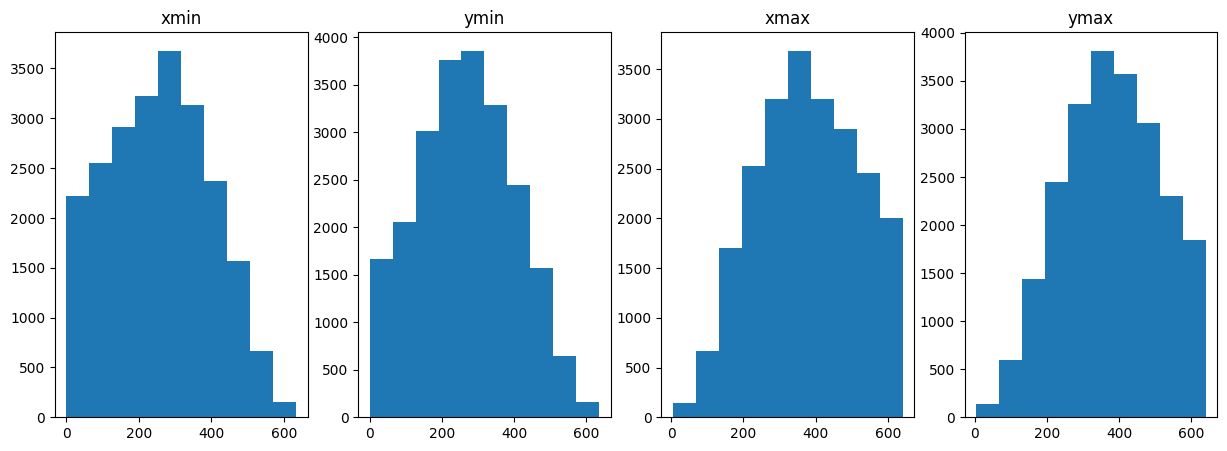

In [6]:
# оценка данных путем отрисовки гистограмм числовых признаков xmin, ymin, xmax, ymax
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
ax1.set_title('xmin')
ax2.set_title('ymin')
ax3.set_title('xmax')
ax4.set_title('ymax')
ax1.hist(df_train['xmin'])
ax2.hist(df_train['ymin'])
ax3.hist(df_train['xmax'])
ax4.hist(df_train['ymax'])
plt.show()

In [7]:
# создание новой колонки bboxes, являющейся списком числовых признаков xmin, ymin, xmax, ymax
df_train['bboxes'] = [[df_train.iloc[i]['xmin'], df_train.iloc[i]['ymin'],
                       df_train.iloc[i]['xmax'], df_train.iloc[i]['ymax']] for i in range(df_train.count()[0])]
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,bboxes
0,cigarette-1529-_jpeg.rf.c5db4049c86b0187cbf9a7...,640,640,smoke,297,214,528,394,"[297, 214, 528, 394]"
1,cigarette-28-_jpg.rf.c5e32cd3a1ebc6532e4d63e5e...,640,640,smoke,270,160,355,257,"[270, 160, 355, 257]"
2,smoke_355_jpg.rf.c5e58fe40887125ada248361b29ef...,640,640,smoke,189,145,235,269,"[189, 145, 235, 269]"
3,cigarette-1221-_jpeg.rf.c5e9bd93ade959ddd1168b...,640,640,smoke,97,171,119,244,"[97, 171, 119, 244]"
4,cigarette-1120-_jpeg.rf.c5f62b254aa12ceebc4366...,640,640,smoke,206,310,334,464,"[206, 310, 334, 464]"


In [8]:
# обрезание того, что не понадобится в работе
df_train = df_train.iloc[:, [0, 8]]
df_train.head()

,filename,bboxes
0,cigarette-1529-_jpeg.rf.c5db4049c86b0187cbf9a7...,"[297, 214, 528, 394]"
1,cigarette-28-_jpg.rf.c5e32cd3a1ebc6532e4d63e5e...,"[270, 160, 355, 257]"
2,smoke_355_jpg.rf.c5e58fe40887125ada248361b29ef...,"[189, 145, 235, 269]"
3,cigarette-1221-_jpeg.rf.c5e9bd93ade959ddd1168b...,"[97, 171, 119, 244]"
4,cigarette-1120-_jpeg.rf.c5f62b254aa12ceebc4366...,"[206, 310, 334, 464]"


In [9]:
# cоздание для каждого изображения единого списка, включающего в себя координаты всех боксов этого изображения
df_train_dict = {}
for i in range(df_train.shape[0]):
  if df_train.iloc[i]['filename'] not in df_train_dict.keys():
    df_train_dict[df_train.iloc[i]['filename']] = []
for i in range(df_train.shape[0]):
  if df_train.iloc[i]['filename'] in df_train_dict.keys():
    # боксы, две крайние точки которых имеют равные значения абсцисс или ординат, игнорируются, так как они являются линиями
    if df_train.iloc[i]['bboxes'][0] != df_train.iloc[i]['bboxes'][2] and df_train.iloc[i]['bboxes'][1] != df_train.iloc[i]['bboxes'][3]:
        df_train_dict[df_train.iloc[i]['filename']].append(df_train.iloc[i]['bboxes'])
train_df = pd.DataFrame({'filename': df_train_dict.keys(), 'bboxes': df_train_dict.values()})
train_df.head()

,filename,bboxes
0,cigarette-1529-_jpeg.rf.c5db4049c86b0187cbf9a7...,"[[297, 214, 528, 394]]"
1,cigarette-28-_jpg.rf.c5e32cd3a1ebc6532e4d63e5e...,"[[270, 160, 355, 257]]"
2,smoke_355_jpg.rf.c5e58fe40887125ada248361b29ef...,"[[189, 145, 235, 269]]"
3,cigarette-1221-_jpeg.rf.c5e9bd93ade959ddd1168b...,"[[97, 171, 119, 244]]"
4,cigarette-1120-_jpeg.rf.c5f62b254aa12ceebc4366...,"[[206, 310, 334, 464]]"


In [10]:
# вывод информации о получившимся датафрейме
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  16713 non-null  object
 1   bboxes    16713 non-null  object
dtypes: object(2)
memory usage: 261.3+ KB


Аналогичную работу проведем с валидационным датафреймом

In [11]:
df_valid.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,640,640,smoke,171,156,184,175
1,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,640,640,smoke,390,68,584,131
2,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,640,640,smoke,91,397,224,495
3,620_jpg.rf.01315ef95b8e54119dfe495606fa75ce.jpg,640,640,smoke,171,208,308,314
4,620_jpg.rf.01315ef95b8e54119dfe495606fa75ce.jpg,640,640,smoke,466,447,509,525


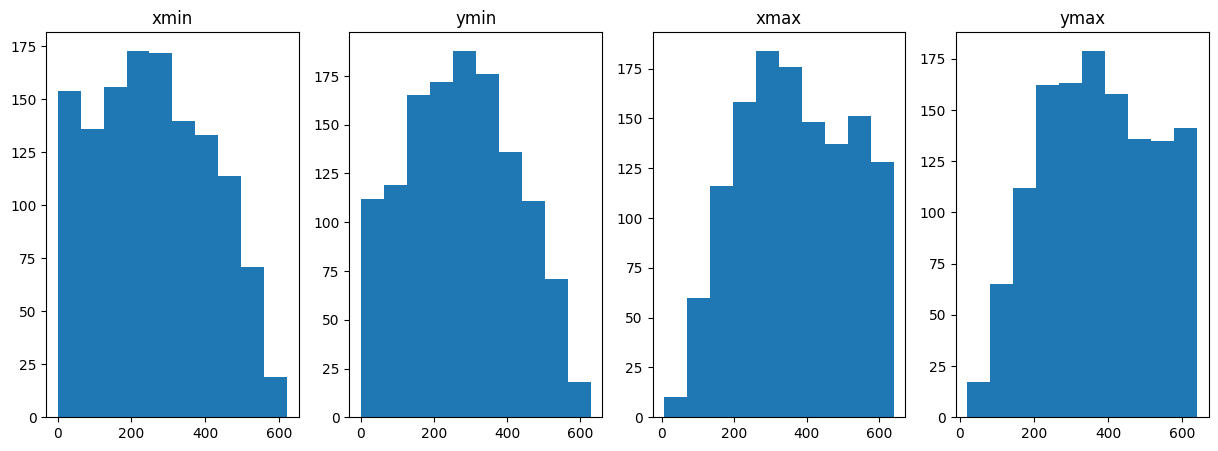

In [12]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
ax1.set_title('xmin')
ax2.set_title('ymin')
ax3.set_title('xmax')
ax4.set_title('ymax')
ax1.hist(df_valid['xmin'])
ax2.hist(df_valid['ymin'])
ax3.hist(df_valid['xmax'])
ax4.hist(df_valid['ymax'])
plt.show()

In [13]:
df_valid['bboxes'] = [[df_valid.iloc[i]['xmin'], df_valid.iloc[i]['ymin'],
                       df_valid.iloc[i]['xmax'], df_valid.iloc[i]['ymax']] for i in range(df_valid.count()[0])]
df_valid.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,bboxes
0,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,640,640,smoke,171,156,184,175,"[171, 156, 184, 175]"
1,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,640,640,smoke,390,68,584,131,"[390, 68, 584, 131]"
2,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,640,640,smoke,91,397,224,495,"[91, 397, 224, 495]"
3,620_jpg.rf.01315ef95b8e54119dfe495606fa75ce.jpg,640,640,smoke,171,208,308,314,"[171, 208, 308, 314]"
4,620_jpg.rf.01315ef95b8e54119dfe495606fa75ce.jpg,640,640,smoke,466,447,509,525,"[466, 447, 509, 525]"


In [14]:
df_valid = df_valid.iloc[:, [0, 8]]
df_valid.head()

,filename,bboxes
0,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,"[171, 156, 184, 175]"
1,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,"[390, 68, 584, 131]"
2,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,"[91, 397, 224, 495]"
3,620_jpg.rf.01315ef95b8e54119dfe495606fa75ce.jpg,"[171, 208, 308, 314]"
4,620_jpg.rf.01315ef95b8e54119dfe495606fa75ce.jpg,"[466, 447, 509, 525]"


In [15]:
df_valid_dict = {}
for i in range(df_valid.shape[0]):
  if df_valid.iloc[i]['filename'] not in df_valid_dict.keys():
    df_valid_dict[df_valid.iloc[i]['filename']] = []
for i in range(df_valid.shape[0]):
  if df_valid.iloc[i]['filename'] in df_valid_dict.keys():
    df_valid_dict[df_valid.iloc[i]['filename']].append(df_valid.iloc[i]['bboxes'])
valid_df = pd.DataFrame({'filename': df_valid_dict.keys(), 'bboxes': df_valid_dict.values()})
valid_df.head()

,filename,bboxes
0,044_jpg.rf.00eade66ea9a93f5c11b53837ddd8a3a.jpg,"[[171, 156, 184, 175], [390, 68, 584, 131], [9..."
1,620_jpg.rf.01315ef95b8e54119dfe495606fa75ce.jpg,"[[171, 208, 308, 314], [466, 447, 509, 525]]"
2,cigarette-1201-_jpeg.rf.017eee6d30fd6375f5453c...,"[[233, 320, 383, 364]]"
3,734_jpg.rf.0343cad607d62e9ec6d2db62cb69ef56.jpg,"[[112, 212, 219, 302]]"
4,607_jpg.rf.0346ad782c3559fc712066c8681d5773.jpg,"[[26, 52, 118, 149], [366, 197, 478, 246], [11..."


In [16]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  738 non-null    object
 1   bboxes    738 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB


## 3. DataLoader

In [17]:
# создание класса Cigarette_Dataset наследующего класс Dataset
class Cigarette_Dataset(Dataset):
    def __init__(self, df, root, transforms=None):
        self.df = df
        self.root = Path(root)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename, bboxes = self.df.iloc[idx]
        img_path = os.path.join(self.root, filename)
        img = Image.open(img_path).convert('RGB')

        boxes = []
        for i in bboxes:
            x0 = i[0]
            y0 = i[1]
            x1 = i[2]
            y1 = i[3]
            boxes.append([x0, y0, x1, y1])

        boxes = torch.tensor(boxes, dtype=torch.int64)

        labels = torch.ones(len(boxes), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

Выведем рандомную картинку из тренировочного датафрейма с изображенными на ней боксами

In [18]:
exapmle_train_ds = Cigarette_Dataset(train_df, '/content/train')
img, target = exapmle_train_ds[56]

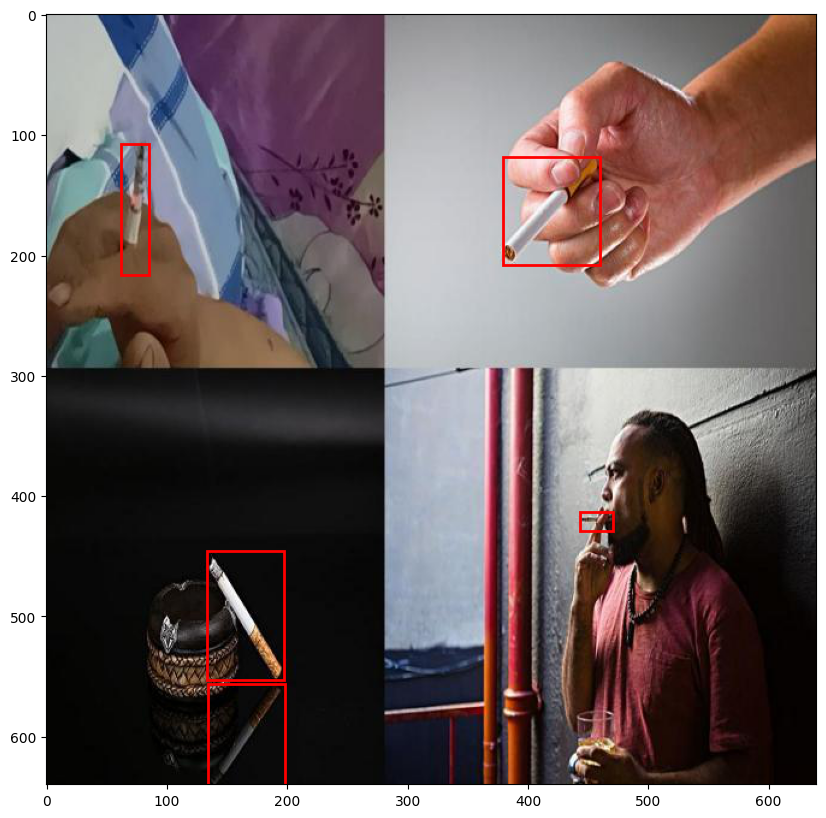

In [19]:
bboxes = target['boxes']

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(img)

for bbox in bboxes:
    x_0, y_0, x_1, y_1 = bbox
    width = abs(x_0-x_1)
    height = abs(y_0-y_1)
    rect = patches.Rectangle((x_0, y_0), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

Загрузим модули необходимые для трансформации изображений, обучения и оценки модели

In [20]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 345514, done.
remote: Counting objects: 100% (61588/61588), done.
remote: Compressing objects: 100% (1286/1286), done.
remote: Total 345514 (delta 60517), reused 61181 (delta 60257), pack-reused 283926
Receiving objects: 100% (345514/345514), 692.10 MiB | 14.35 MiB/s, done.
Resolving deltas: 100% (318574/318574), done.


In [21]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# трансформация изображения
def get_transforms(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float32))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [22]:
# инициализация train_ds и valid_ds датасетов
train_ds = Cigarette_Dataset(train_df, '/content/train',
                             get_transforms(train=True))
valid_ds = Cigarette_Dataset(valid_df, '/content/valid',
                             get_transforms(train=False))

In [23]:
# инициализация train_dl и valid_dl даталоадеров
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True,
                                       collate_fn=utils.collate_fn)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=8, shuffle=False,
                                       collate_fn=utils.collate_fn)

## 4. Загрузка модели, ее обучение и оценка

Для данной задачи детекции сигарет на изображениях в качестве модели была выбрана Fast R-CNN, являющаяся улучшенной версией модели R-CNN. В основе Fast R-CNN лежит следующиая архитектура:\
1) Изображение подается на вход сверточной нейронной сети и обрабатывается selectivesearch. В итоге, имеем карту признаков и регионы потенциальных объектов.\
2) Координаты регионов потенциальных объектов преобразуются в координаты на карте признаков.\
3) Полученная карта признаков с регионами передается слою RoI (Region of Interest) polling layer. Здесь на каждый регион накладывается сетка размером HxW. Затем применяется MaxPolling для уменьшения размерности. Так, все регионы потенциальных объектов имеют одинаковую фиксированную размерность.\
4) Полученные признаки подаются на вход полносвязного слоя (Fully-conectedlayer), который передается двум другим полносвязным слоям. Первый с функцией активацией softmax определяет вероятность принадлежности классу, второй – границы (смещение) региона потенциального объекта.

![image.png](https://1.bp.blogspot.com/--SAC2nqf7ms/Xg4WzX-p37I/AAAAAAAEoj8/1XntXMj23t8x7JJnhb5PSmYmbwtag_VfACLcBGAsYHQ/s1600/Fast%2BR-CNN%2Barchitecture.png)

In [24]:
# определение устройства
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [25]:
# загрузка модели
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 1 класс принадлежит сигаретам, другой - фону
num_classes = 2

# количество входных в классификатор признаков
in_features = model.roi_heads.box_predictor.cls_score.in_features

# заменияем обученную голову на новую
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 61.9MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [26]:
# задание оптимизатора
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [27]:
# количество эпох
num_epochs = 5

for epoch in range(num_epochs):
    # обучение внутри одной эпохи и вывод состояния каждые 10 итераций
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # оценка модели на валидационном даталоадере
    evaluate(model, valid_dl, device=device)

Epoch: [0]  [   0/2090]  eta: 6:33:54  lr: 0.000010  loss: 0.6676 (0.6676)  loss_classifier: 0.5223 (0.5223)  loss_box_reg: 0.0889 (0.0889)  loss_objectness: 0.0515 (0.0515)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 11.3085  data: 0.3316  max mem: 7206
Epoch: [0]  [  10/2090]  eta: 1:23:31  lr: 0.000060  loss: 0.6421 (0.6295)  loss_classifier: 0.4881 (0.4757)  loss_box_reg: 0.0943 (0.1003)  loss_objectness: 0.0515 (0.0466)  loss_rpn_box_reg: 0.0064 (0.0068)  time: 2.4095  data: 0.1184  max mem: 7364
Epoch: [0]  [  20/2090]  eta: 1:08:40  lr: 0.000110  loss: 0.5801 (0.5529)  loss_classifier: 0.4025 (0.3811)  loss_box_reg: 0.1059 (0.1135)  loss_objectness: 0.0412 (0.0507)  loss_rpn_box_reg: 0.0064 (0.0076)  time: 1.5249  data: 0.0873  max mem: 7365
Epoch: [0]  [  30/2090]  eta: 1:03:40  lr: 0.000160  loss: 0.4176 (0.5304)  loss_classifier: 0.1964 (0.3095)  loss_box_reg: 0.1154 (0.1168)  loss_objectness: 0.0498 (0.0932)  loss_rpn_box_reg: 0.0093 (0.0109)  time: 1.5497  data: 0.0766  max m

In [41]:
# функция отрисовки бокса на изображении
def draw_predict(index, filename, mode = 'save', threshold = 0.8):
    iou_threshold = 0.1
    scale_percent = 25
    img = cv2.imread(filename)
    img_ = img / 255
    img_ =torch.from_numpy(img_).permute(2,0,1).unsqueeze(0).to(torch.float).to(device)
    model.eval()
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img,
                         (int(box[0]), int(box[1])),
                         (int(box[2]), int(box[3])),
                         (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim)
    if mode == 'show':
        cv2_imshow(img)
    elif mode == 'save':
      # index - индекс для изображения, которое необходимо сохранить
      cv2.imwrite(f'/content/drive/MyDrive/Тестовое задание/Predictions/prediction_{index}.jpg', img)

Оценим качество отрисовки боксов обученной модели, изобразив ее предсказание на рандомной картинке валидационного датафрейма, оставив значение threshold в функции draw_predict дефолтным

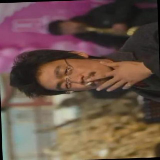

In [42]:
draw_predict(10, '/content/valid/000015_jpg.rf.6c0f60a512280b8fe9b03ccf459f84d4.jpg', 'show')

Мы видим, что бокса на изображении нет, поэтому попробуем уменьшить значение threshold до 0.2

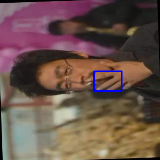

In [43]:
draw_predict(10, '/content/valid/000015_jpg.rf.6c0f60a512280b8fe9b03ccf459f84d4.jpg', 'show', 0.2)

Хоть бокс и появился, его местоположение на изображении явно не такое, какое мы бы ожидали увидеть, поэтому для отрисовки боксов на тестовых изображениях оставим значение threshold равное 0.8

In [44]:
# итерируемся по изображениям, на которых нужно предсказать бокс
path = Path('/content/drive/MyDrive/Тестовое задание/image')
N = 0
for filename in os.listdir('/content/drive/MyDrive/Тестовое задание/image'):
    draw_predict(N, str(path/filename))
    N += 1

Напоследок, сохраним веса модели

In [31]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Тестовое задание/weights.pth')